# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
tar: Error opening archive: Failed to open 'VOCtrainval_11-May-2012.tar'


In [ ]:
!pip install scipy==1.1.0

^C


### 1.1 Loading the dataset

In [ ]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + 
                             ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], 
                                     [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", 
                         im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            # uint8 with RGB mode
            img = img.resize((self.img_size[0], self.img_size[1]))
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in 
                     sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [ ]:
import torch.nn as nn

class Segnet(nn.Module):
    # Upsample works with "minibatch x channels x height x width"-tensors
  
    def __init__(self, num_classes=21, weights=None):
        """
        @param num_classes: number of classes to distinguish
        @param weights: file with old weights for this network as a warm start 
            to not relearn all the weights again
        """
        super(Segnet, self).__init__()
        
        self.num_classes = num_classes

        # input channels, output channels, kernel_size
        self.d_conv11 = nn.Conv2d(3, 16, 3, padding=1)
        self.b_norm11 = nn.BatchNorm2d(16)
        self.d_conv12 = nn.Conv2d(16, 16, 3, padding=1)
        self.b_norm12 = nn.BatchNorm2d(16)
        
        self.d_conv21 = nn.Conv2d(16, 32, 3, padding=1)
        self.b_norm21 = nn.BatchNorm2d(32)
        self.d_conv22 = nn.Conv2d(32, 32, 3, padding=1)
        self.b_norm22 = nn.BatchNorm2d(32)
        
        self.d_conv31 = nn.Conv2d(32, 64, 3, padding=1)
        self.b_norm31 = nn.BatchNorm2d(64)
        self.d_conv32 = nn.Conv2d(64, 64, 3, padding=1)
        self.b_norm32 = nn.BatchNorm2d(64)
        
        self.d_conv41 = nn.Conv2d(64, 128, 3, padding=1)
        self.b_norm41 = nn.BatchNorm2d(128)
        self.d_conv42 = nn.Conv2d(128, 128, 3, padding=1)
        self.b_norm42 = nn.BatchNorm2d(128)
        
        self.b_conv51 = nn.Conv2d(128, 256, 3, padding=1)
        self.b_conv52 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.u_conv41 = nn.Conv2d(256, 128, 3, padding=1)
        self.u_conv42 = nn.Conv2d(256, 128, 3, padding=1)
        
        self.u_conv31 = nn.Conv2d(128, 64, 3, padding=1)
        self.u_conv32 = nn.Conv2d(128, 64, 3, padding=1)
        
        self.u_conv21 = nn.Conv2d(64, 32, 3, padding=1)
        self.u_conv22 = nn.Conv2d(64, 32, 3, padding=1)
        
        self.u_conv11 = nn.Conv2d(32, 16, 3, padding=1)
        self.u_conv12 = nn.Conv2d(32, 16, 3, padding=1)
        
        self.o_conv01 = nn.Conv2d(16, 16, 3, padding=1)
        self.o_conv02 = nn.Conv2d(16, self.num_classes, 3, padding=1)
        
        if weights is not None:
            self.load(weights)
  
    def forward(self, x):
        # dimensionality comments are given as width x height x channels,
        # nevertheless, the input should be channels first!!!
        
        # x = 512x512x3
        x = self.d_conv11(x)
        x = nn.ReLU()(x)
        x = self.b_norm11(x)

        # x = 512x512x16
        x1 = self.d_conv12(x)
        x = nn.MaxPool2d(2)(x1)
        x = nn.ReLU()(x)
        x = self.b_norm12(x)

        # x = 256x256x16
        x = self.d_conv21(x)
        x = nn.ReLU()(x)
        x = self.b_norm21(x)

        # x = 256x256x32
        x2 = self.d_conv22(x)
        x = nn.MaxPool2d(2)(x2)
        x = nn.ReLU()(x)
        x = self.b_norm22(x)

        # x = 128x128x32
        x = self.d_conv31(x)
        x = nn.ReLU()(x)
        x = self.b_norm31(x)

        # x = 128x128x64
        x3 = self.d_conv32(x)
        x = nn.MaxPool2d(2)(x3)
        x = nn.ReLU()(x)
        x = self.b_norm32(x)

        # x = 64x64x64
        x = self.d_conv41(x)
        x = nn.ReLU()(x)
        x = self.b_norm41(x)

        # x = 64x64x128
        x4 = self.d_conv42(x)
        x = nn.MaxPool2d(2)(x4)
        x = nn.ReLU()(x)
        x = self.b_norm42(x)

        # x = 32x32x128
        x = self.b_conv51(x)
        x = nn.ReLU()(x)
        
        # x = 32x32x256
        x = self.b_conv52(x)
        x = nn.ReLU()(x)
        
        # x = 32x32x256
        x = nn.Upsample(scale_factor=2)(x)
        # x = 64x64x256
        x = self.u_conv41(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x4), dim=1)
        x = self.u_conv41(x)
        x = nn.ReLU()(x)
        
        # x = 64x64x128
        x = nn.Upsample(scale_factor=2)(x)
        # x = 128x128x128
        x = self.u_conv31(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x3), dim=1)
        x = self.u_conv32(x)
        x = nn.ReLU()(x)
        
        # x = 128x128x64
        x = nn.Upsample(scale_factor=2)(x)
        # x = 256x256x64
        x = self.u_conv21(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x2), dim=1)
        x = self.u_conv22(x)
        x = nn.ReLU()(x)
        
        # x = 256x256x32
        x = nn.Upsample(scale_factor=2)(x)
        # x = 512x512x32
        x = self.u_conv11(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x1), dim=1)
        x = self.u_conv12(x)
        x = nn.ReLU()(x)
        
        x = self.o_conv01(x)
        x = nn.ReLU()(x)
        x = self.o_conv02(x)
        
        return x
    
    def classify(self, x):
        return self.forward(x).argmax(dim=1)
    
    def save(self, file_name):
        torch.save(self.state_dict(), file_name)
    
    def load(self, file_name):
        self.load_state_dict(torch.load(file_name))

In [ ]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.

# model = Segnet().to(device)
model = Segnet(weights='/content/drive/My Drive/Project/weights/network_epoch249.pth').to(device)
print("Model has", 
      sum(p.numel() for p in model.parameters() if p.requires_grad), 
      "parameters")

Model has 1968933 parameters


### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [ ]:
# modify project_root_dir according to your device
project_root_dir = "/content/drive/My Drive/Project"
local_path = project_root_dir + '/data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/'
batch_size = 16
start_epoch = 0
end_epoch = 250
learning_rate = 0.001
weighted_loss = False

'''
the weights for the CE-Loss are computed by counting the occurrences in the
solution-masks of the train_aug dataset given above. After summing this up into
a 21-dimensional vector we compute the actual weights as the quotient of the 
total number of pixels in all images of the dataset and the number of 
occurrences of a single class. So, the classes are weighted antiproportional to
their frequency.
Because this feature in not used in other implementation of this or similar
tasks, we left it out.
'''
weights = torch.tensor([1.3430940387071182, 116.4971625395112, 
                        272.7166120445353, 112.22833380853163, 
                        155.90548632359608, 158.07671880850202, 
                        57.761409034756284, 71.85013757683176, 
                        38.8753618302696, 91.72158977250213, 
                        120.50800034540416, 78.64502108348, 
                        62.279856790615504, 111.59948983597633, 
                        92.09545916487988, 22.616427610560393, 
                        148.97187660969738, 118.59421204814363, 
                        73.02657358784822, 66.65363207665139, 
                        114.32628401491507]).to(device)


### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [ ]:
# dataset variable
# this step takes once around 15 minutes to create the masks
dst = pascalVOCDataset(root=local_path, is_transform=True)

# dataloader variable
trainloader = data.DataLoader(dst, batch_size=batch_size, shuffle=True)

KeyboardInterrupt: ignored

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [ ]:
# loss function
# as this is a classification task, the CrossEntropyLoss an appropriate choice
if weighted_loss:
    loss_f = nn.CrossEntropyLoss(weight=weights)
else:
    loss_f = nn.CrossEntropyLoss()

# optimizer variable
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [ ]:
# some general statistics
episode_losses = []
episode_accuracies = []

for e in range(start_epoch, end_epoch):
    
    # some episode statistics
    episode_loss = 0
    episode_accuracy = 0
    
    for i, d in enumerate(trainloader):
        
        # forwarding the data through the network and compute the loss
        output = model.forward(d[0].to(device))
        loss = loss_f(output, d[1].to(device))
        
        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # do some statistics
        loss = loss.item()
        episode_loss += loss

        accuracy = torch.sum(output.argmax(dim=1).squeeze() == d[1].to(device)).item() / (512*512*batch_size)
        episode_accuracy += accuracy

        print("\rEpisode", e + 1, "/", end_epoch, "- Batch", i + 1, "/", 
              len(dst) // batch_size, "\tLoss:", loss, "\tAcc:", accuracy, end="")
    
    '''
    update the general statistics (the trainingset has a total of 1464 images)
    
    Dividing by i is not 100% correct, because the last batch might be smaller
    but for evaluation issues, this can be ignored, because the general trend is
    shown
    '''
    episode_losses.append(episode_loss / i)
    episode_accuracies.append(episode_accuracy / i)
    print("\rEpisode", e + 1, "/", end_epoch, "- Completed \tLoss:", 
          episode_losses[-1], "\tAcc:", episode_accuracies[-1])

    # save the models weights
    model.save(F"{project_root_dir}/weights/network_epoch{e}.pth")


Episode 138 / 250 - Completed 	Loss: 0.35795725063308254 	Acc: 0.9015983592022906
Episode 139 / 250 - Completed 	Loss: 0.32367063927781453 	Acc: 0.9094268253871373
Episode 140 / 250 - Completed 	Loss: 0.3399465873346224 	Acc: 0.9059825729537796
Episode 141 / 250 - Completed 	Loss: 0.349796073449837 	Acc: 0.9039647736392178
Episode 142 / 250 - Completed 	Loss: 0.32515506069738787 	Acc: 0.9114024350931357
Episode 143 / 250 - Completed 	Loss: 0.3251780970738484 	Acc: 0.9104865278516497
Episode 144 / 250 - Completed 	Loss: 0.308012686751701 	Acc: 0.9149950834421011
Episode 145 / 250 - Completed 	Loss: 0.33905588761790767 	Acc: 0.9065316876212319
Episode 146 / 250 - Completed 	Loss: 0.3310818677092647 	Acc: 0.9082057790441828
Episode 147 / 250 - Completed 	Loss: 0.3000752038353092 	Acc: 0.9184057502956181
Episode 148 / 250 - Completed 	Loss: 0.30871780806190363 	Acc: 0.9158731816889165
Episode 149 / 250 - Completed 	Loss: 0.3065129688807896 	Acc: 0.9167762903066782
Episode 150 / 250 - Compl

TypeError: ignored

In [ ]:
# these are the data we've got from training. In order to no retrain the net
# every time, we inserted them here.
episode_losses = [1.6362308794325524, 1.3070307760448245, 1.2929355999925634, 1.279103154009515, 1.2673020592102637, 1.2521888797099774, 1.2223723439069896, 1.2211400932008094, 1.200173815528115, 1.1951436210464645, 1.1930503026469723, 1.180759337577191, 1.171391432756906, 1.1712533713697078, 1.1649841207724352, 1.1706791539768597, 1.157470695920043, 1.1475963441880195, 1.1402156156497998, 1.147625995861305, 1.1439611957623408, 1.1233760635931413, 1.1253557722647112, 1.1158855308543194, 1.105228813794943, 1.098717899767907, 1.1061324942242967, 1.0924514970936618, 1.0922302387572906, 1.0915783224525033, 1.0824545648071793, 1.078774435179574, 1.067918979204618, 1.0698945640207647, 1.0643201883022602, 1.0515047036684477, 1.056991417984386, 1.052365936420776, 1.0443707475295434, 1.0488923205124152, 1.0270570667235406, 1.0269373648769253, 1.027617368069324, 1.0218418535295424, 1.007022540647905, 0.9937355813089308, 0.9953128977136297, 0.991768404022678, 0.9882102137083536, 0.9751647697700249, 0.9746461432058733, 0.9658609681077056, 0.9502522716155419, 0.9570618108078673, 0.935844824209318, 0.9422272103173392, 0.9374249204174503, 0.9254239732092553, 0.9162528586911631, 0.9139602328394796, 0.9102122292413817, 0.8915317687359485, 0.8896636766391796, 0.8899653743911575, 0.870321531872173, 0.8587247539352585, 0.8566107533790253, 0.8523180465121846, 0.8354719444945619, 0.8476205330628616, 0.819610032078984, 0.8089253535637488, 0.7962140761888944, 0.799044301876655, 0.7772897809416384, 0.7685360564635351, 0.7738057663152506, 0.7503594539977692, 0.730605885877714, 0.7238108970961727, 0.741964768577408, 0.7140192176614489, 0.7221095247583075, 0.6986997120982998, 0.6807184988980765, 0.6821192873048258, 0.6675746126489325, 0.6656772736664657, 0.6508250341310606, 0.6442975441178123, 0.6418552998003069, 0.636208842088888, 0.6107117166885963, 0.5897939637467101, 0.5965610804793599, 0.5929018642221179, 0.5929820170769324, 0.5636957025789953, 0.5620653717727452, 0.5552237986863314, 0.5756766946761163, 0.5416357608941885, 0.5528824136152373, 0.5338007152735532, 0.5185909382589571, 0.5092799067497253, 0.5110876052589207, 0.49733418553740116, 0.5019898332737305, 0.4908564031779111, 0.48614999848407703, 0.48105195754176966, 0.4649803887356769, 0.4929288953215211, 0.4685438668334877, 0.5178355466533493, 0.43998569561229955, 0.42929312881532605, 0.42362724932340473, 0.4229190786788752, 0.44334747732340635, 0.4447964713141158, 0.40656030161695167, 0.42003690803443994, 0.4006892688326783, 0.38458884613854544, 0.3707589854250897, 0.39104115062362543, 0.4377360524057032, 0.3843490034341812, 0.3781577820306296, 0.3866197175377018, 0.3681833090690466, 0.3463565707206726, 0.33799346479085773, 0.3345930889085099, 0.3517697119450831, 0.35795725063308254, 0.32367063927781453, 0.3399465873346224, 0.349796073449837, 0.32515506069738787, 0.3251780970738484, 0.308012686751701, 0.33905588761790767, 0.3310818677092647, 0.3000752038353092, 0.30871780806190363, 0.3065129688807896, 0.305070582981948, 0.30086760026413006, 0.3417475097454511, 0.3124994755118758, 0.28855543575444065, 0.2689635560407743, 0.27935623975245505, 0.3009027340909937, 0.2995454708298484, 0.29345428992758743, 0.2701461162868437, 0.2767804243734905, 0.29480713786004664, 0.27807292817058143, 0.27037526175871, 0.2646119976109201, 0.2486462455529433, 0.2841558500633135, 0.2527101220010401, 0.26469364320183847, 0.2769828961118237, 0.24007019449721326, 0.2495462471967215, 0.2596067090283383, 0.2634560362650798, 0.23398439324164128, 0.2260162612566581, 0.24666523253852193, 0.23928123188542796, 0.2691880043718841, 0.2599786565853999, 0.21890578951154435, 0.23048767922343788, 0.22985122672149114, 0.2281365739283981, 0.20578651711508467, 0.21271314316398496, 0.20847991510079458, 0.20277060715706793, 0.23384780772439726, 0.21220178541901347, 0.3521580065672214, 0.2231746297943723, 0.23170548914880543, 0.19387991579024347, 0.1896861696636284, 0.17376855097629212, 0.18885119554105695, 0.19314736962973417, 0.20134490458192406, 0.18697470893244167, 0.22033173828334598, 0.21161661321645256, 0.19247123075055553, 0.17768528689067442, 0.17638443115648333, 0.18051817071634335, 0.22938952554058242, 0.260078245139384, 0.235924434367117, 0.1896257718185802, 0.18300622316834692, 0.17348339883508263, 0.17178611490097676, 0.18936880203066292, 0.17961149220610714, 0.22995921347167467, 0.17768871694148242, 0.1530600912295855, 0.20014421690951337, 0.17196549491567925, 0.1785363448517663, 0.1753217475591125, 0.1902938479414353, 0.17968384528553094, 0.22011125087738037, 0.18233806860970928, 0.1865173137777454, 0.15548081876157405, 0.16277009396107642, 0.18196581025699993, 0.1573704243688793, 0.1519547007404841, 0.16093688482766624, 0.15420522270621834, 0.1524116818557729, 0.18084177121028797, 0.1520392324079524, 0.1514278034587483, 0.16100333974911615, 0.2144469262643175, 0.20574767601031524, 0.18340489923299014, 0.17013557189768488, 0.13819828121871738, 0.13305770401116257, 0.13724450316730435, 0.18953065164796598, 0.22262909075061044, 0.1944860604765651, 0.16081881343008397]
episode_accuracies = [0.7245292506375156, 0.7486380692366715, 0.7486404246026344, 0.7486404350825718, 0.7485619482103285, 0.7485706544184423, 0.7484130964174376, 0.7485008134946718, 0.7492819382594182, 0.7489066726558811, 0.7488095655546083, 0.749698172558795, 0.7492952818398947, 0.7493500473735096, 0.7499892475840809, 0.7499516508081457, 0.7500248767517426, 0.7502325262342181, 0.7507452231187087, 0.7501975677825592, 0.7509080368083912, 0.7509922378665799, 0.750854743706001, 0.750601902112856, 0.7511051722935268, 0.7517932221129701, 0.7505739678393354, 0.7519052264454601, 0.7521164364867158, 0.7509802697779058, 0.7513986865242759, 0.7516382395566165, 0.7530412542950976, 0.7545766647045429, 0.7541622696342049, 0.7541537913647327, 0.7534148824083936, 0.753608525454343, 0.7552539699680203, 0.7547895803556337, 0.7563626347007332, 0.7550148754329472, 0.7562319472595885, 0.7564563358223045, 0.7576364265693413, 0.7594392535450695, 0.7581753835573302, 0.7587128366742816, 0.7579730343032669, 0.7605546778374976, 0.7603582366482242, 0.7612183094024658, 0.7620772241236089, 0.7614828675657839, 0.7643418154873691, 0.7643932562607986, 0.7647419552226643, 0.7673307932340182, 0.767726678114671, 0.7659541433984107, 0.7681010869833139, 0.7715288754347917, 0.770524928857992, 0.7708382501706972, 0.775176567035717, 0.7756561289776812, 0.7766103037111052, 0.7779025166899294, 0.7800064846709535, 0.7792261799613198, 0.7827391205253181, 0.786606796495207, 0.7885467665536063, 0.7858913311591516, 0.7910473346710205, 0.7935859161418873, 0.7930059013785896, 0.7945636628748296, 0.8003329968714452, 0.8016783929133153, 0.7982664579873556, 0.803402976675348, 0.8016750314733484, 0.8046334261422629, 0.8084760367215335, 0.8083988755613893, 0.8126191726097693, 0.8132047862796993, 0.8169013798891843, 0.8194396391019716, 0.8186362235100715, 0.8195302591219054, 0.8252351755624289, 0.8305150886158367, 0.8296686109605727, 0.8318690965463827, 0.8309461782266806, 0.8361370484907549, 0.8376602497729626, 0.8408176925156142, 0.8366285182617523, 0.8427808258559678, 0.8410635151705899, 0.8469300348680098, 0.8503668020059775, 0.8515935939746898, 0.8537754802913456, 0.8584006356668996, 0.8557003566196987, 0.8595947014106499, 0.8627302568037432, 0.8632690199128874, 0.8668695386949477, 0.8605048918462062, 0.8665018003065508, 0.8533237661634173, 0.875153620164473, 0.8779580147711785, 0.8798522844419374, 0.8803795536795815, 0.8740607906173874, 0.8738715648651123, 0.8862636508522453, 0.8823347825270432, 0.8867806314112066, 0.8929791371900957, 0.8953754875686143, 0.8900055911514785, 0.8789438939356542, 0.8924400151430906, 0.8922462227580311, 0.8925187011341472, 0.8966036550291292, 0.9036428116180084, 0.9046668744349218, 0.9062644020541684, 0.9025445482233069, 0.9015983592022906, 0.9094268253871373, 0.9059825729537796, 0.9039647736392178, 0.9114024350931357, 0.9104865278516497, 0.9149950834421011, 0.9065316876212319, 0.9082057790441828, 0.9184057502956181, 0.9158731816889165, 0.9167762903066782, 0.9168761745913998, 0.9176964524028065, 0.9064434255872454, 0.9157061367244511, 0.9214916674645393, 0.9273715412223732, 0.9244081790630634, 0.9188763178311862, 0.9204079371232253, 0.9222789570525453, 0.9280168748163915, 0.9265335889963003, 0.9224245312449696, 0.9262723398732615, 0.9279301664331457, 0.9307109130607857, 0.9352955503778143, 0.9252420100536976, 0.934536962718754, 0.9321093716464199, 0.9292431401682424, 0.9380443724957142, 0.9358334567520644, 0.9334908317733597, 0.9320535135793162, 0.9410735277029184, 0.9434956246679955, 0.9364276246710138, 0.9391473125625442, 0.930960149555416, 0.9346237025418125, 0.946401331450913, 0.9415527778667409, 0.9430634346637097, 0.9426579947000021, 0.949041662635384, 0.9471572414859311, 0.9487177382458697, 0.950177279147473, 0.9412379186232012, 0.949463739499941, 0.911124410210075, 0.944555177793398, 0.9415489317296626, 0.9526912773048485, 0.9543736321585519, 0.9587145847278636, 0.9541223573160695, 0.9533371794354785, 0.9505861539107102, 0.9553334555783115, 0.9459149103898269, 0.9478793353824825, 0.9533770267780011, 0.9581700340732113, 0.9583368615789728, 0.9573245467720451, 0.944343857712798, 0.9354400660965468, 0.942426364500444, 0.9550127354297009, 0.9572207613305731, 0.9600000695867853, 0.960323684818142, 0.9555529683500856, 0.958081609600193, 0.9424195813608693, 0.9583097028208303, 0.9660520081991678, 0.9517849801660894, 0.960649257177835, 0.9588409465747875, 0.9592826759422218, 0.9557474550310072, 0.9587408579312838, 0.9473536093156416, 0.9575197591886415, 0.9564661612877479, 0.9656561809581715, 0.9627373532934503, 0.9579911991790101, 0.9644502440651694, 0.9667247022901263, 0.964671294767778, 0.9656115940638951, 0.9669884954180036, 0.9581371087294358, 0.9665760365161267, 0.9667998591622153, 0.964574926502102, 0.949647028367598, 0.951730843428727, 0.9580968893491305, 0.9614349459553813, 0.9708049873729329, 0.9722513733329353, 0.971232105087448, 0.957038334437779, 0.9477248715830373, 0.9564520369519244, 0.9655327246739314]

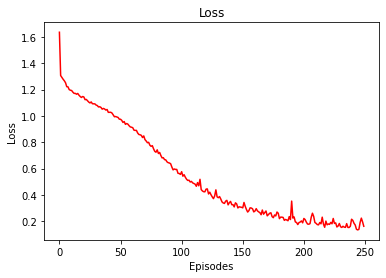

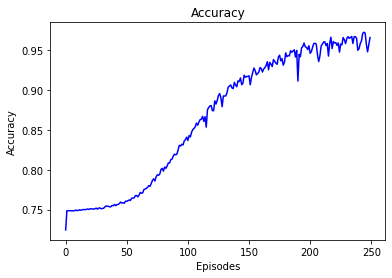

In [ ]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.plot(episode_losses, "r")
plt.show()

plt.title("Accuracy")
plt.xlabel("Episodes")
plt.ylabel("Accuracy")
plt.plot(episode_accuracies, "b")
plt.show()

In [ ]:
# save lines!
f = open(project_root_dir + "/weights/losses.csv", "a")
f.write(",".join([str(l) for l in episode_losses]) + "\n")
f.flush()
f.close()

f = open(project_root_dir + "/weights/accuracy.csv", "a")
f.write(",".join([str(l) for l in episode_accuracies]) + "\n")
f.flush()
f.close()

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, jaccard_score


def image_auc(ground_truth, prediction):
    # prediction should be the classification
    p = prediction.view(21, 512*512).softmax(dim=0).transpose(0, 1).detach().numpy()
    g = ground_truth.view(512*512).detach().numpy()

    # this is done to enure that every class occurrs at least once in the true
    # labels. This is necessary, otherwise sklearn cannot compute the 
    # One-vs-all setting of the AUC. This will give not 100% correct results, 
    # but changing at most 21 of 262144 pixels (8*10^(-3)%) is not dramatic.
    for i in range(21):
        g[i] = i

    return roc_auc_score(g, p, average="weighted", multi_class="ovr", labels=list(range(21)))


def image_f1(ground_truth, prediction):
    return f1_score(ground_truth, prediction, average='weighted')


def image_dice(ground_truth, prediction):
    jaccard = jaccard_score(ground_truth, prediction, average='weighted')
    return (2 * jaccard) / (1 + jaccard)

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [ ]:
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool

# dataset variable
# this step takes once around 15 minutes to create the masks
# val_dst = pascalVOCDataset(root=local_path, is_transform=True)

# dataloader variable
dst = pascalVOCDataset(root=local_path, is_transform=True)
valloader = data.DataLoader(dst, batch_size=1, shuffle=False)

f1_scores, aucs, dices = [], [], []

# inserting a dummy element >a< because the threadpool seems to have a problem
# with a single int argument to the function
def eval_epoch(epoch, a):
    # initialize the model
    model = Segnet(weights=F"{project_root_dir}/weights/network_epoch{e}.pth").to(device)
    f1, auc, dice = 0, 0, 0
    for i, d in enumerate(valloader):
        if i == 10:
            break
        ground_truth = d[1].squeeze()
        with torch.no_grad():
            prediction = model.forward(d[0].to(device)).cpu().squeeze()
        
        label_array = ground_truth.view(512*512).detach().numpy()
        prediction_array = prediction.argmax(dim=0).squeeze().view(512*512).detach().numpy()

        f1 += image_f1(label_array, prediction_array)
        auc += image_auc(ground_truth, prediction)
        dice += image_dice(label_array, prediction_array)
    
    return f1 / i, auc / i, dice / i


pool = ThreadPool(processes=cpu_count())
tasks = [None for _ in range(end_epoch)]
print("Multiprocess on", cpu_count(), "threads")

for e in range(end_epoch):
    tasks[e] = pool.apply_async(eval_epoch, args=(e, 0))

for e in range(end_epoch):
    # f1_score, auc_score, dice_coefficient = eval_epoch(e)
    image_f1_score, image_auc_score, image_dice_coefficient = tasks[e].get()
    f1_scores.append(image_f1_score)
    aucs.append(image_auc_score)
    dices.append(image_dice_coefficient)
    print("Episode", e + 1, "/", end_epoch, "- F1:", image_f1_score, "| AUC:", 
            image_auc_score, "| Dice:", image_dice_coefficient)

Multiprocess on 2 threads
Episode 1 / 250 - F1: 0.6801461522303801 | AUC: 0.5164945178283105 | Dice: 0.7261917669188889
Episode 2 / 250 - F1: 0.6801461522303801 | AUC: 0.5164945178283105 | Dice: 0.7261917669188889
Episode 3 / 250 - F1: 0.6801461522303801 | AUC: 0.5164945178283105 | Dice: 0.7261917669188889
Episode 4 / 250 - F1: 0.6801461522303801 | AUC: 0.5164945178283105 | Dice: 0.7261917669188889
Episode 5 / 250 - F1: 0.6801476065691404 | AUC: 0.49302571587700417 | Dice: 0.7261935699262458
Episode 6 / 250 - F1: 0.6801476065691404 | AUC: 0.5549567780495418 | Dice: 0.7261935699262458


KeyboardInterrupt: ignored

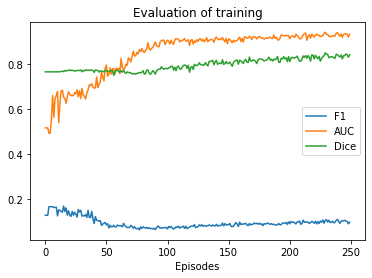

In [ ]:
plt.plot(f1_scores, label="F1")
plt.plot(aucs, label="AUC")
plt.plot(dices, label="Dice")
plt.legend(loc="right")
plt.xlabel("Episodes")
plt.title("Evaluation of training")
plt.show()

In [ ]:
dst = pascalVOCDataset(root=local_path, is_transform=True)
valloader = data.DataLoader(dst, batch_size=1, shuffle=False)
model = Segnet(weights='/content/drive/My Drive/Project/weights/network_epoch249.pth').to(device)
image, label = next(iter(valloader))

In [ ]:
from sklearn.metrics import f1_score, jaccard_score

def f1(ground_truth, prediction):
    return f1_score(ground_truth, prediction, average='weighted')


def dice(ground_truth, prediction):
    jaccard = jaccard_score(ground_truth, prediction, average='weighted')
    return (2 * jaccard) / (1 + jaccard)


# ground_truth is 512x512
# prediction 512x512x21 (keine PD! (für PD: softmax(dim=1)))
# classification 512x512

with torch.no_grad():
    prediction = model.forward(image.to(device)).cpu()
classification = prediction.argmax(dim=0).cpu().squeeze()
label_array = label.view(512*512).detach().numpy()
prediction_array = prediction.argmax(dim=1).squeeze().view(512*512).detach().numpy()

print("F1:", f1(label_array, prediction_array), "| Dice:", dice(label_array, prediction_array))

F1: 0.9297551942483739 | Dice: 0.9473158592562797


### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

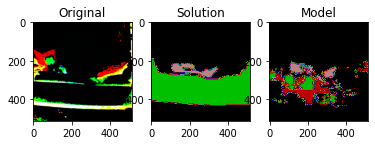

Pixel Accuracy: 0.7099952697753906



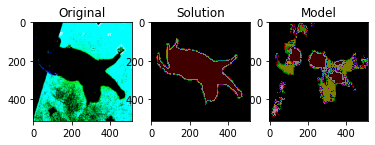

Pixel Accuracy: 0.7997245788574219



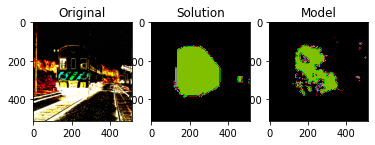

Pixel Accuracy: 0.9118309020996094



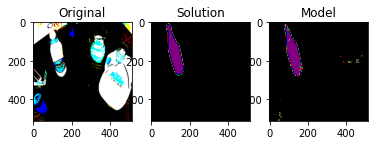

Pixel Accuracy: 0.9909400939941406



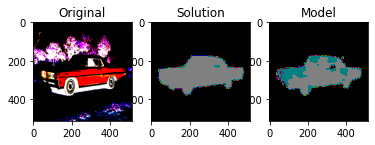

Pixel Accuracy: 0.9511032104492188



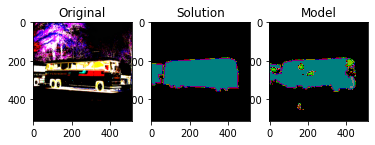

Pixel Accuracy: 0.9499435424804688



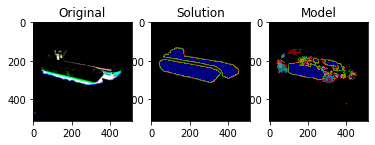

Pixel Accuracy: 0.9049263000488281



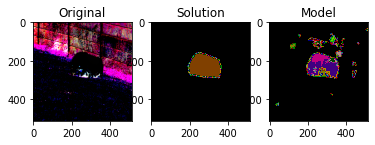

Pixel Accuracy: 0.9120330810546875



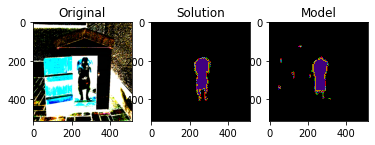

Pixel Accuracy: 0.9866447448730469



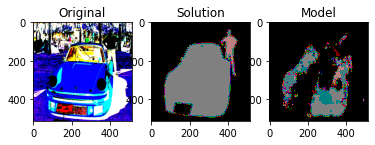

Pixel Accuracy: 0.6905097961425781



In [ ]:
from matplotlib import colors

torch.manual_seed(4711)
valloader = data.DataLoader(dst, batch_size=1, shuffle=True)
valloader = iter(valloader)

cmap = colors.ListedColormap(dst.get_pascal_labels() / 255)
bounds = list(range(22))
norm = colors.BoundaryNorm(bounds, cmap.N)

for _ in range(10):
    image, solution = next(valloader)

    fig = plt.figure()
    im1 = fig.add_subplot(131)
    im1.imshow(image[0].transpose(0, 2).transpose(0, 1).numpy().astype('uint8'))
    im1.title.set_text("Original")
    
    im2 = fig.add_subplot(132)
    im2.imshow(solution[0].numpy().astype('uint8'), cmap=cmap, norm=norm)
    im2.title.set_text("Solution")
    
    im3 = fig.add_subplot(133)
    with torch.no_grad():
        model_output = model.classify(image.to(device)).squeeze().cpu()
    im3.imshow(model_output.numpy().astype('uint8'), cmap=cmap, norm=norm)
    im3.title.set_text("Model")
    plt.show()

    '''
    plt.subplot(132)
    plt.imshow(solution[0], cmap=cmap, norm=norm)
    
    plt.subplot(133)
    model_output = model.classify(image.to(device)).squeeze().cpu()
    plt.imshow(model_output, cmap=cmap, norm=norm)
    plt.show()
    '''
    print("Pixel Accuracy:", torch.sum(model.classify(
        image.to(device)).squeeze() == solution.to(device)).item() / (512*512), end="\n\n")